<a href="https://colab.research.google.com/github/mehadisaki/ASDS-Thesis/blob/main/ARIMA_MLP_hybrid_19052022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# library

In [2]:
! pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 40.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
from pathlib import Path
import pandas as pd
from scipy import stats
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Link to drive

In [110]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/TS - forcast project/new_image'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Function

##MLP

In [80]:
import numpy as np
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
#from keras.optimizers import SGD
from keras.optimizers import gradient_descent_v2
from sklearn.model_selection import TimeSeriesSplit
from keras.constraints import maxnorm
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import tensorflow as tf
#from Models.Misc import *
from sklearn.model_selection import RandomizedSearchCV
import keras.backend as K


SGD = gradient_descent_v2


tf.random.set_seed(123)




def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Function to convert a time series into a supervised learning problem.
    ...

    Attributes
    ----------
    df : Dataframe
        Dataframe of stock data.
    attribute : list
        List of columns used for creating the supervised learning problem. 
    list_of_prev_t_instants : list
    
    df : list
    
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy



def find_input_dim(data):
    
    """
    Function to find the number of terms above 0.9 autocorrelation in a data set.
    ...

    Attributes
    ----------
    data : list, Dataframe
    
    """
    
    acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(data,
                                                                 adjusted=True,
                                                                 nlags=500,
                                                                 qstat=True,
                                                                 fft=True,
                                                                 alpha = 0.05)
    
    plt.figure(figsize=(7, 5))
    plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
    plt.title('Autocorrelation of Delivery Qty', weight='bold', fontsize=16)
    plt.xlabel('Lag', weight='bold', fontsize=14)
    plt.ylabel('Value', weight='bold', fontsize=14)
    plt.xticks(weight='bold', fontsize=12, rotation=45)
    plt.yticks(weight='bold', fontsize=12)
    plt.grid(True)
    
    input_dim = sum([1 for x in acf_djia if x>0.8])
    print("Number of values above 0.8 autocorrelation is: ", input_dim)
    return input_dim



def build_baseline_model(num_of_input):
    
    """
    Function to build the baseline model.
    ...

    Attributes
    ----------
    num_of_input : int
        Dimension of the input layer.
    
    """
    
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=num_of_input, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def get_mlp_model(input_dim, hidden_layer_one=50, hidden_layer_two=25,
    dropout=0.2, learn_rate=0.01):
    
    """
    Function to build the MLP model. The parameters of the model will be optimised by the optimize_parameters() function.
    ...

    Attributes
    ----------
    input_dim: int
        Dimension of the input layer.
    hidden_layer_one: int
        Size of the first hidden layer. Default value = 50.
    hidden_layer_two: int
        Size of the second hidden layer. Default value = 25.
    dropout: float
        Rate of dropout of the dropout layer. Default value = 0.2.
    learn_rate: float
        Amount of learning rate. Default value = 0.01.
        
    """
    
    # initialize a sequential model and add layer to flatten the
    # input data
    model = Sequential()
    #model.add(Flatten())
    
    model.add(Dense(hidden_layer_one, activation="relu",
        input_dim=input_dim))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layer_two, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=learn_rate),
        loss="mean_squared_error",
        metrics=["mse", "mae"])
    # return compiled model
    return model
    



    
def baseline_test(n_iter, input_dim, X_train, y_train, X_valid, y_valid, X_test, y_test, scaler):
    
    
    """
    Function to fit the baseline model and make prediction for n_iter amount of times.
    ...

    Attributes
    ----------
    n_iter: int
        Number of times the baseline test is ran.
    input_dim: int
        Dimension of the input layer.
    X_train: list
    y_train: list
    X_valid: list
    y_valid: list
    X_test: list
    y_test: list
    scaler: Scaler object
    
    """
        
    baseline_MSE=[]
    baseline_MAE=[]
        
    
    for i in range(n_iter):
        model = build_baseline_model(input_dim)
        # train the network (i.e., no hyperparameter tuning)
        print("[INFO] training model...")
        H = model.fit(x=X_train, y=y_train,
            validation_data=(X_valid, y_valid),
            batch_size=128,
            epochs=100, verbose=0, shuffle=False)
            # mke predictions on the test set and evaluate it
        
        
        baseline_pred = model.predict(X_test)
        baseline_pred_rescaled = scaler.inverse_transform(baseline_pred)
        
        
        #plot_comparison_graph(y_test, baseline_pred_rescaled)
        #plot_loss(H)
        
        measures = calculate_error_measures(y_test, baseline_pred_rescaled)
        baseline_MSE.append(measures[0])
        baseline_MAE.append(measures[1])
        
        K.clear_session()
    
    

    return sum(baseline_MSE)/n_iter, sum(baseline_MAE)/n_iter




def optimize_parameters(model, grid, X_train, y_train):
    
    """
    Function to optimise the MLP hyperparameters using RandomizedSearchCV. 
    ...

    Attributes
    ----------
    model: KerasRegressor object
        The model to be optimised. Wrapped in a KerasRegressor object for compatibility with the sklearn library.
    grid: dictionary
        Dictionary of list with the hyperparameter values used for optimisation.
    X_train: list
    y_train: list
        
    """
    
    tss = TimeSeriesSplit(n_splits=10)
    
    
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, n_iter=10, cv=tss,
        param_distributions=grid, scoring=('neg_mean_squared_error','neg_mean_absolute_error'), refit='neg_mean_squared_error')
    search_results = searcher.fit(X_train, y_train)
    best_params = search_results.best_params_
    print("Best parameters are: {}".format(best_params))
    
    return best_params







##Hybrid

In [6]:
#from Models.Misc import *
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



def forecast_HMLP_residuals(input_dim_hybrid, X_train, y_train, X_valid, y_valid, X_test):
    
    """
    Function to build the HMLP and forecast the residuals.
    ...

    Attributes
    ----------
    input_dim_hybrid: int
        Dimension of the input layer for the HMLP.
    X_train: list
    y_train: list
    X_valid: list
    y_valid: list
    X_test: list
    
    """
    #
    ## define model
    model = Sequential()
    model.add(Dense(input_dim_hybrid, activation='tanh', input_dim=input_dim_hybrid))
    model.add(Dense(input_dim_hybrid/2, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(
            optimizer=Adam(learning_rate=0.01),
            loss="mean_squared_error",
            metrics=["mse", "mae"])
    
    model.summary()
    
    history_hybrid = model.fit(X_train, y_train,
                               validation_data=(X_valid, y_valid),
                               batch_size=32,
                               epochs=100, verbose=False)
    
    pred_HMLP = model.predict(X_test)
    
    return pred_HMLP, history_hybrid


def zero_centre(prediction):
    
    """
    Function to zero center the hybrid prediction.
    ...

    Attributes
    ----------
    prediction : list
    
    """
    
    if prediction[0] < 0:
        prediction = [abs(prediction[0])+i for i in prediction]
    if prediction[0] > 0:
        prediction = [i-prediction[0] for i in prediction]
    else:
        return prediction
    return prediction



##Misc

In [132]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import time



def calculate_error_measures(X, Y):
    
    """
    Function to calculate the mean squared error, mean absolute error and the coefficient of determination (r2) between two lists.
    ...

    Attributes
    ----------
    X : list
    
    Y : list
    
    """
    
        
    MSE = mean_squared_error(X, Y)
    print('Mean Squared Error(MSE): ', MSE)
    
    MAE = mean_absolute_error(X, Y)
    print('Mean Absolute Error(MAE): ', MAE)
    RMSE =mean_squared_error(X, Y,squared=False)
    print('Root Mean Squared Error(RMSE):', RMSE )
    MAPE = mean_absolute_percentage_error(X, Y)
    print(' Mean absolute percentage Error(MAPE):', MAPE )
    #squared bool, default=True If True returns MSE value, if False returns RMSE value.
    error_measures = [MSE, MAE,RMSE, MAPE]
    return error_measures



def create_train_valid_test(data, test_set_size, valid_set_size):
    
    """
    Function to split a dataset into training, testing and validation sets.
    ...

    Attributes
    ----------
    data : list
        
    test_set_size : int
        Int <= 1 for size of test set.
        
    valid_set_size : int
        Int <= 1 for size of validation set.   
    """
    
    
    df_copy = data.reset_index(drop=True)
    
    df_test = df_copy.iloc[ int((len(df_copy)*(1-test_set_size))) : ]
    df_train_plus_valid = df_copy.iloc[ : int((len(df_copy)*(1-test_set_size))) ]
    
    df_train = df_train_plus_valid.iloc[ : int((len(df_train_plus_valid)*(1-valid_set_size))) ]
    df_valid = df_train_plus_valid.iloc[ int((len(df_train_plus_valid)*(1-valid_set_size))) : ]
    
    X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
    X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
    X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]
    
    
    
    print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
    print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
    print('Shape of test inputs, test target:', X_test.shape, y_test.shape)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test


def scale_data(X_train, y_train, X_valid, y_valid, X_test, y_test, scaler):
    
    """
    Function to transform features by scaling them into a range a given range. A range of 0-1 is used for this project.
    ...

    Attributes
    ----------
    X_train : list
    
    y_train : list
    
    X_valid : list
    
    y_valid : list
        
    X_test : list
    
    y_test : list
    
    scaler : MinMaxScaler
    """
    
    
    X_train_scaled = scaler.fit_transform(np.array(X_train))
    X_valid_scaled = scaler.fit_transform(np.array(X_valid))
    X_test_scaled = scaler.fit_transform(np.array(X_test))
    
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
    y_valid_scaled = scaler.fit_transform(np.array(y_valid).reshape(-1,1))
    y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1,1))
    
    return X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled


def plot_comparison_graph(actual, prediction,mn ):
    
    """
    Function to plot a graph comparing the actual values to predicted values.
    ...

    Attributes
    ----------
    actual : list
    mn= model number
    
    prediction : list   
    """
    timestamp = time.time()
    
    y_actual = pd.DataFrame(actual, columns=['Actual Delivery'])

    y_hat = pd.DataFrame(prediction, columns=['Predicted Delivery'])
    
    
    plt.figure(figsize=(11, 6))
    plt.plot(y_actual, linestyle='solid', color='r')
    plt.plot(y_hat, linestyle='dashed', color='b')
    
    plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
    plt.title('32" TV delivery', weight='bold', fontsize=16)
    plt.ylabel('Pcs', weight='bold', fontsize=14)
    plt.xlabel('Test Set Month no.', weight='bold', fontsize=14)
    plt.xticks(weight='bold', fontsize=12, rotation=45)
    plt.yticks(weight='bold', fontsize=12)
    plt.grid(True)
    
    
    plt.show()
    
    
def plot_loss(history):
    
    """
    Function to plot the training and validation loss of the MLP model.
    ...

    Attributes
    ----------
    history :  History object  
    """
    
    plt.figure(figsize=(11, 6))
    history_dict=history.history
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    plt.plot(loss_values,'bo',label='Training loss')
    plt.plot(val_loss_values,'ro',label='Validation loss')
    plt.legend()
    images_dir = '/content/gdrive/My Drive/TS - forcast project/new_image'
    plt.savefig("history_loss-1.png")
    plt.savefig(f"{images_dir}/history_loss-1.png")
    plt.show()
    
    
def comparison_graph(actual, prediction ):
    
    """
    Function to plot a graph comparing the actual values to predicted values.
    ...

    Attributes
    ----------
    actual : list
    mn= model number
    
    prediction : list   
    """
    timestamp = time.time()
    
    y_actual = pd.DataFrame(actual, columns=['Actual Delivery'])

    y_hat = pd.DataFrame(prediction, columns=['Predicted Delivery'])
    
    return y_actual, y_hat

    

def load_data(ETF):
    
    """
    Function to load the ETF data from a file, remove NaN values and set the Date column as index.
    ...

    Attributes
    ----------
    ETF : filepath
    """
    
    
    data = pd.read_excel(ETF,parse_dates=[0], header=0)

    data.dropna(subset = ['Month', 'Delivery'], inplace=True)
    
    data_close = pd.DataFrame(data['Delivery'])
    data_close.index = pd.to_datetime(data['Month'])
    
    return data_close



def equal_size(list1, list2):
    
    """
    Function to equalise the size of two lists.
    ...

    Attributes
    ----------
    list1: list
    list2: list
    
    """
    
    if len(list1) > len(list2):
        s = len(list1)-len(list2)
        list1 = list1[:-s]
        return list1, list2
    if len(list2) > len(list1):
        s = len(list2)-len(list1)
        list2 = list2[:-s]
        return list1, list2
    else:
        return list1, list2
        


## Box-cox Function

In [18]:
# Box-Cox Transformation Function
def run_box_cox(pd_dataframe):
    """
    Perform Box-Cox Transformation on column 'price'
    Save the resutls into a new column 'price_box'
    Save lmbda into a new column 'lmbda'
    """
    
    sns.set(style="darkgrid")
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)   
    
    ax1 = axes[0, 0]    
    prob = stats.probplot(pd_dataframe['Delivery'], dist=stats.norm, plot=ax1, fit=False)    
    ax1.set_title('Probability Plot Before Transformation')
        
    ax2 = axes[0, 1]
    # Perform Box-Cox Transformation
    box_cox, lmbda = stats.boxcox(pd_dataframe['Delivery'])
    # Record new column 'price_box' in pd
    pd_dataframe['Delivery'] = pd.Series(box_cox, index=pd_dataframe.index)
    # Record lmbda in pd
    print(lmbda)
    #pd_dataframe['lmbda'] = lmbda
    prob = stats.probplot(box_cox, dist=stats.norm, plot=ax2, fit=False)
    ax2.set_title('Probability Plot After Transformation')    
    
    ax3 = axes[1, 0]
    sns.kdeplot(pd_dataframe['Delivery'], shade=True, ax=ax3, label='KDE')
    ax3.set_title('KDE Plot Before Transformation')
    
    ax4 = axes[1, 1]
    sns.kdeplot(box_cox, shade=True, ax=ax4, label='KDE after Transformation', color='r')
    ax4.set_title('KDE Plot After Transformation')
    
    f.suptitle('32"TV {} delivery after Box-Cox Transformation'.format("Monthly"), fontsize=16)
    f.subplots_adjust(top=0.91, hspace=0.3)

    plt.savefig("boxcox.png")
    plt.savefig(f"{images_dir}/boxcox.png")
    plt.show()
    return lmbda

##ARIMA

In [9]:
from pmdarima.arima import ndiffs
import statsmodels.tsa.arima.model as sm
import matplotlib.pyplot as plt
import pandas as pd
#from statsmodels.tsa.arima import ARIMA
from statsmodels.tsa.arima.model import ARIMA 
import time
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



def find_differencing (train_data):
    
    """
    Function to find the maximum differencing from two unit tests - ADF and KPSS.
    ...

    Attributes
    ----------
    train_data : list
    
    """
    
    
    kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=5)
    adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=5)
    n_diffs = max(adf_diffs, kpss_diffs)
    
    print(f"Estimated differencing term: {n_diffs}")
    return n_diffs


def stepwise_ARIMA(train_data, test_data, optimal_order):
    
    """
    Function to perform stepwise ARIMA forecasting.
    ...

    Attributes
    ----------
    train_data : list
    
    test_data : list
    
    optimal_order : tuple
        Optimal order of the ARIMA model, determined by the auto_arima function in the pmdarima library.
   
    """
    
    history = [x for x in train_data]
    model_predictions = []
    N_test_observations = len(test_data)
    for time_point in range(N_test_observations):
        model = ARIMA(history, order=optimal_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
    return model_predictions
    
    
def ARIMA_pred(train_data, test_data, optimal_order):
    
    """
    Function to perform an ARIMA forecast and plot the results.
    ...

    Attributes
    ----------
    train_data : list
    
    test_data : list
    
    optimal_order : tuple
        Optimal order of the ARIMA model, determined by the auto_arima function in the pmdarima library.
   
    """
    timestamp = time.time()

    
    # Build Model
    model = ARIMA(train_data, order=optimal_order)  
    fitted = model.fit()  
    print(fitted.summary())
        
    # Forecast
    #fc, se, conf = fitted.forecast(len(test_data), alpha=0.10)
    fcast = fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()
    # Make as pandas series
    #fc_series = pd.Series(fc, index=test_data.index)
    #lower_series = pd.Series(conf[:, 0], index=test_data.index)
    #upper_series = pd.Series(conf[:, 1], index=test_data.index)
    
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.grid(True)
    plt.plot(train_data, label='training')
    plt.plot(test_data, label='actual')
    plt.plot(fcast['mean'],'g--', label='mean_forecast')
    #plt.plot(fc_series, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
                     #color='k', alpha=0.15)
    plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    
    #plt.savefig('Reports/{}.png'.format(timestamp))

    
    plt.show()
    
    return fcast


# Preperation

Data adding

In [372]:
url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/TV%20Delivery_2016-2022.xlsx?raw=true'
#url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/walton%20TV%20Delivery_2016-2022-m.xlsx?raw=true'
# taking link from view raw'

## indexing with datetime
df =pd.read_excel(url,index_col='Month',parse_dates=['Month'])
df.sort_index(inplace = True)
df32= df[['Delivery']].loc[df["SIZE"] == "32\" ( 813 mm )"]
#df32.reset_index(inplace=True)
#data_close  = df32.rename(columns = {'index':'date'})


In [11]:
df32.head()

,Delivery
Month,
2016-01-01,4513
2016-02-01,5225
2016-03-01,5583
2016-04-01,5493
2016-05-01,4864


##Box-cox transform

In [373]:
df32_t = df32.copy()


0.5811077391636348


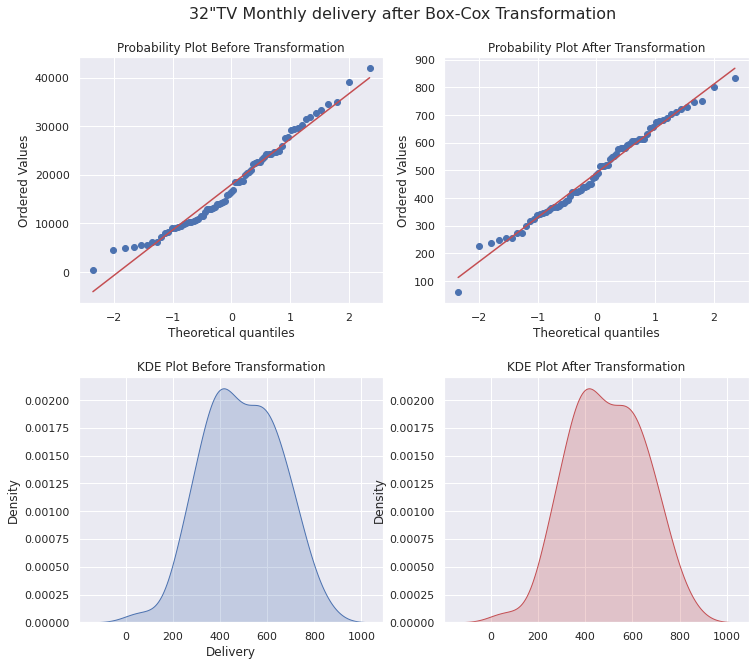

0.5811077391636348

In [374]:
run_box_cox(df32_t)

In [23]:
df32_t.head()

,Delivery
Month,
2016-01-01,227.039855
2016-02-01,247.366722
2016-03-01,257.146403
2016-04-01,254.713169
2016-05-01,237.216385


##Plot the Delivery data

In [ ]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Delivery')
plt.plot(data_close['Delivery'])
plt.title('32" TV Delivery From Jan 2016 - March 2022')
plt.show()

 Find the input dimention for slpiting

Number of values above 0.6 autocorrelation is:  3


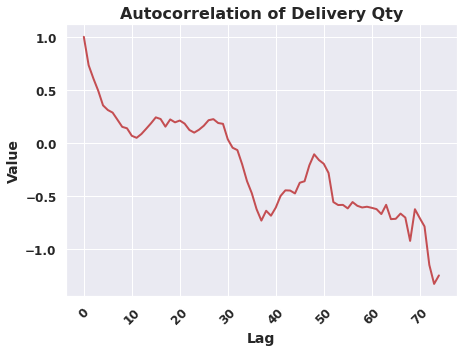

In [29]:
input_dim = find_input_dim(df32_t)

## Data Split

In [36]:
train_data, test_data = train_test_split(df32_t, test_size=0.20, shuffle = False)

#print(train_data)
print(test_data.tail())

              Delivery
Month                 
2021-11-01  520.669397
2021-12-01  473.998192
2022-01-01  580.455440
2022-02-01  631.989152
2022-03-01  608.033667


In [37]:
print(train_data.head())

              Delivery
Month                 
2016-01-01  227.039855
2016-02-01  247.366722
2016-03-01  257.146403
2016-04-01  254.713169
2016-05-01  237.216385


# Model

## ARIMA

### ARIMA-1


In [44]:
# Build Model
#timestamp = time.time()
# model order from auto arima 
model_1 = ARIMA(train_data, order=(0, 1, 1),seasonal_order=(0,0,0,0), enforce_stationarity=True, )  
fitted = model_1.fit()  

print(fitted.summary())
fcast = fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()

                               SARIMAX Results                                
Dep. Variable:               Delivery   No. Observations:                   60
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -358.938
Date:                Thu, 19 May 2022   AIC                            721.875
Time:                        15:52:18   BIC                            726.031
Sample:                    01-01-2016   HQIC                           723.497
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2337      0.077     -3.038      0.002      -0.384      -0.083
sigma2      1.125e+04   1428.140      7.879      0.000    8453.348    1.41e+04
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### ARIMA-2

In [45]:
# Build Model
#timestamp = time.time()
# model order from auto arima 
model_2 = ARIMA(train_data, order=(1, 1, 1),seasonal_order=(1,1,1,12), enforce_stationarity=True, )  
fitted2 = model_2.fit()  

print(fitted2.summary())
fscast = fitted2.get_forecast(len(test_data), alpha=0.05).summary_frame()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                    SARIMAX Results                                     
Dep. Variable:                         Delivery   No. Observations:                   60
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -294.073
Date:                          Thu, 19 May 2022   AIC                            598.145
Time:                                  15:52:26   BIC                            607.396
Sample:                              01-01-2016   HQIC                           601.626
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7093      0.241      2.948      0.003       0.238       1.181
ma.L1         -0.9995     27.367     -0.037      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### ARIMA-3

In [48]:
# Build Model
#timestamp = time.time()
# model order from auto arima 
model_3 = ARIMA(train_data, order=(1, 1, 1),seasonal_order=(2,1,0,12), enforce_stationarity=True, )  
fitted3 = model_3.fit()  

print(fitted3.summary())
fscast3 = fitted3.get_forecast(len(test_data), alpha=0.05).summary_frame()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          Delivery   No. Observations:                   60
Model:             ARIMA(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -294.155
Date:                           Thu, 19 May 2022   AIC                            598.310
Time:                                   15:53:21   BIC                            607.561
Sample:                               01-01-2016   HQIC                           601.791
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7145      0.244      2.932      0.003       0.237       1.192
ma.L1         -0.9996     28.781     -0.035

## MLP

Convert dataset to suppervise learning setting

### MLP-1

In [375]:
# data_close = df32
columns_mlp = ['Delivery']
#
input_dim1 =4
n_lags_mlp = []
for i in range(1, input_dim1+1):
    n_lags_mlp.append(i)

df_new1 = create_regressor_attributes(df32_t, columns_mlp, n_lags_mlp)

df_new1.shape

(71, 5)

In [376]:
df32_t.head(11)

,Delivery,datetime
Month,,
2016-01-01,227.039855,2016-01-01
2016-02-01,247.366722,2016-02-01
2016-03-01,257.146403,2016-03-01
2016-04-01,254.713169,2016-04-01
2016-05-01,237.216385,2016-05-01
2016-06-01,347.460223,2016-06-01
2016-07-01,342.110282,2016-07-01
2016-08-01,378.075126,2016-08-01
2016-09-01,323.154525,2016-09-01


In [377]:
df_new1.head()

,Delivery,Delivery_(t-1),Delivery_(t-2),Delivery_(t-3),Delivery_(t-4)
datetime,,,,,
2016-05-01,237.216385,254.713169,257.146403,247.366722,227.039855
2016-06-01,347.460223,237.216385,254.713169,257.146403,247.366722
2016-07-01,342.110282,347.460223,237.216385,254.713169,257.146403
2016-08-01,378.075126,342.110282,347.460223,237.216385,254.713169
2016-09-01,323.154525,378.075126,342.110282,347.460223,237.216385


### MLP-2

In [393]:
# data_close = df32
columns_mlp = ['Delivery']
#
input_dim2 =10
n_lags_mlp = []
for i in range(1, input_dim2+1):
    n_lags_mlp.append(i)

df_new2 = create_regressor_attributes(df32_t, columns_mlp, n_lags_mlp)

df_new2.shape

(65, 11)

In [371]:
df32_t.head()

,Delivery,datetime
Month,,
2016-01-01,227.039855,2016-01-01
2016-02-01,247.366722,2016-02-01
2016-03-01,257.146403,2016-03-01
2016-04-01,254.713169,2016-04-01
2016-05-01,237.216385,2016-05-01


In [90]:
df_new2.head()

,Delivery,Delivery_(t-1),Delivery_(t-2),Delivery_(t-3),Delivery_(t-4),Delivery_(t-5),Delivery_(t-6),Delivery_(t-7),Delivery_(t-8),Delivery_(t-9),Delivery_(t-10)
datetime,,,,,,,,,,,
2016-11-01,298.502386,363.251814,323.154525,378.075126,342.110282,347.460223,237.216385,254.713169,257.146403,247.366722,227.039855
2016-12-01,449.238995,298.502386,363.251814,323.154525,378.075126,342.110282,347.460223,237.216385,254.713169,257.146403,247.366722
2017-01-01,540.728957,449.238995,298.502386,363.251814,323.154525,378.075126,342.110282,347.460223,237.216385,254.713169,257.146403
2017-02-01,438.638565,540.728957,449.238995,298.502386,363.251814,323.154525,378.075126,342.110282,347.460223,237.216385,254.713169
2017-03-01,614.705522,438.638565,540.728957,449.238995,298.502386,363.251814,323.154525,378.075126,342.110282,347.460223,237.216385


###MLP-3

In [392]:
# data_close = df32
columns_mlp = ['Delivery']
#
input_dim3 =8
n_lags_mlp = []
for i in range(1, input_dim3+1):
    n_lags_mlp.append(i)

df_new3 = create_regressor_attributes(df32_t, columns_mlp, n_lags_mlp)

df_new3.shape

(67, 9)

## Split for MLP

In [394]:
#test_set_size=0.2, valid_set_size=0.1
X_train, y_train, X_valid, y_valid, X_test, y_test = create_train_valid_test(df_new2, 0.20, 0.10)

Shape of training inputs, training target: (46, 10) (46,)
Shape of validation inputs, validation target: (6, 10) (6,)
Shape of test inputs, test target: (13, 10) (13,)


###Scaling

In [395]:
scaler = MinMaxScaler()

X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled = scale_data(X_train, y_train, X_valid, y_valid, X_test, y_test, scaler)

### reverse scale

In [396]:
y_test_rescaled = scaler.inverse_transform(y_test_scaled)

In [381]:
y_test_rescaled 

array([[576.84194665],
       [613.5225871 ],
       [750.93405601],
       [597.0652431 ],
       [546.80622332],
       [608.17895046],
       [520.14943487],
       [490.237268  ],
       [801.68949887],
       [550.98167673],
       [520.66939672],
       [473.99819161],
       [580.4554399 ],
       [631.98915189],
       [608.03366705]])

## Baseline test

### MLP-1

In [397]:
baseline_test(10, input_dim2, X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_rescaled, scaler)

[INFO] training model...
Mean Squared Error(MSE):  21787.994857042464
Mean Absolute Error(MAE):  115.18925688305589
Root Mean Squared Error(RMSE): 147.60757045979202
 Mean absolute percentage Error(MAPE): 0.17726221828466932
[INFO] training model...
Mean Squared Error(MSE):  22098.779063039055
Mean Absolute Error(MAE):  116.86243240138522
Root Mean Squared Error(RMSE): 148.6565809610831
 Mean absolute percentage Error(MAPE): 0.18019084101534633
[INFO] training model...
Mean Squared Error(MSE):  22098.779063039055
Mean Absolute Error(MAE):  116.86243240138522
Root Mean Squared Error(RMSE): 148.6565809610831
 Mean absolute percentage Error(MAPE): 0.18019084101534633
[INFO] training model...
Mean Squared Error(MSE):  22098.779063039055
Mean Absolute Error(MAE):  116.86243240138522
Root Mean Squared Error(RMSE): 148.6565809610831
 Mean absolute percentage Error(MAPE): 0.18019084101534633
[INFO] training model...
Mean Squared Error(MSE):  22098.779063039055
Mean Absolute Error(MAE):  116.86

(21231.685350796983, 113.9457010471161)

### MLP-2

#### Model

In [398]:
# wrap model into a scikit-learn compatible regressor
model = KerasRegressor(build_fn=get_mlp_model, verbose=0, input_dim=input_dim2)
# define a grid of the hyperparameter search space
hidden_layer_one = [25, 50, 100]
hidden_layer_two = [5, 10, 25]
learn_rate = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2 , 0.3, 0.4, 0.5]
batch_size = [4, 8, 16, 32, 64, 128]
epochs = [10, 50, 100, 500, 1000]
# create a dictionary from the hyperparameter grid
grid = dict(
    hidden_layer_one=hidden_layer_one,
    hidden_layer_two=hidden_layer_two,
    dropout=dropout,
    learn_rate=learn_rate,
    batch_size=batch_size,
    epochs=epochs
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Find the best parameters

In [399]:
best_parameters = optimize_parameters(model, grid, X_train_scaled, y_train_scaled)


hidden_layer_one=best_parameters['hidden_layer_one']
hidden_layer_two=best_parameters['hidden_layer_two']
dropout=best_parameters['dropout']
learn_rate=best_parameters['learn_rate']
batch_size=best_parameters['batch_size']
epochs=best_parameters['epochs']


best_model = get_mlp_model(input_dim2, hidden_layer_one=hidden_layer_one, hidden_layer_two=hidden_layer_two,
    dropout=dropout, learn_rate=learn_rate)

[INFO] performing random search...
Best parameters are: {'learn_rate': 0.0001, 'hidden_layer_two': 25, 'hidden_layer_one': 50, 'epochs': 1000, 'dropout': 0.2, 'batch_size': 32}


In [159]:
#Early Stopp
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 0, patience = 25, verbose=1, restore_best_weights=True)


history = best_model.fit(x=X_train_scaled, y=y_train_scaled,
    validation_data=(X_valid_scaled, y_valid_scaled),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=es,
    shuffle=False,
    verbose=False)

MLP_pred = best_model.predict(X_test_scaled)
MLP_pred_rescaled = scaler.inverse_transform(MLP_pred)

Restoring model weights from the end of the best epoch: 1.
Epoch 26: early stopping


In [105]:
MLP_pred_rescaled

array([[607.29694],
       [605.9836 ],
       [578.9576 ],
       [615.6362 ],
       [588.4267 ],
       [615.76355],
       [625.2431 ],
       [556.0319 ],
       [565.2271 ],
       [623.742  ],
       [580.7949 ],
       [611.0915 ],
       [646.08575],
       [558.28143],
       [562.5606 ]], dtype=float32)

## Plot MLP

In [160]:

y_actual,y_hat = comparison_graph(y_test_rescaled, MLP_pred_rescaled)


print("Error measures for MLP1:")
calculate_error_measures(y_test_rescaled, MLP_pred_rescaled)

Error measures for MLP1:
Mean Squared Error(MSE):  11534.69598202615
Mean Absolute Error(MAE):  81.9941279351457
Root Mean Squared Error(RMSE): 107.39970196432647
 Mean absolute percentage Error(MAPE): 0.1283975316282119


[11534.69598202615, 81.9941279351457, 107.39970196432647, 0.1283975316282119]

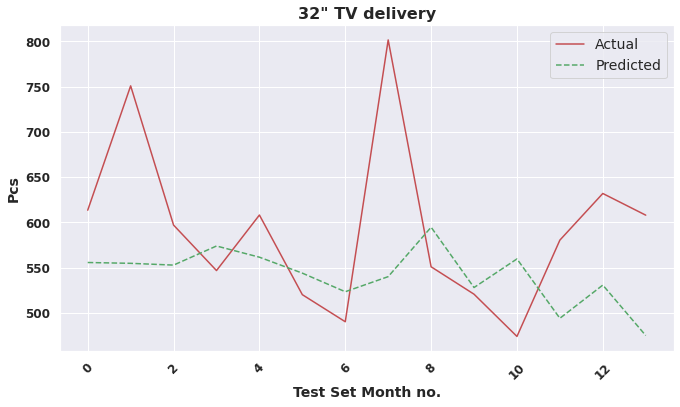

In [161]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='g')
    
plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('32" TV delivery', weight='bold', fontsize=16)
plt.ylabel('Pcs', weight='bold', fontsize=14)
plt.xlabel('Test Set Month no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(True)
    
plt.savefig("Comperisom_ML_3.png")
plt.savefig(f"{images_dir}/Comperisom_ML_3.png")   
plt.show()

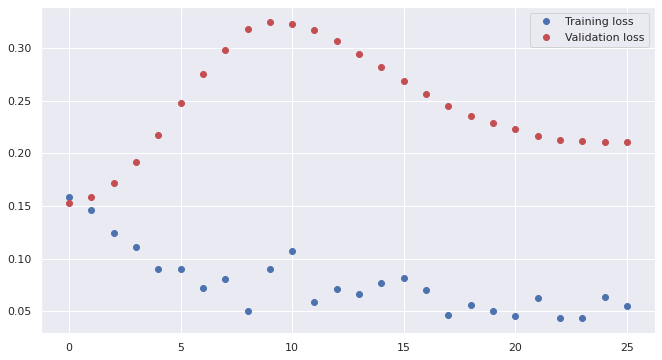

In [162]:
plot_loss(history)

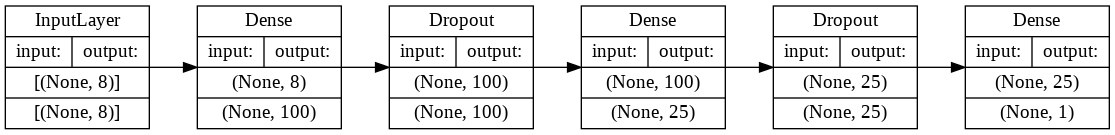

In [163]:
plot_model(best_model,
    #to_file="Reports/MLP.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=96)
 #images_dir = '/content/gdrive/My Drive/TS - forcast project/new_image'



## Hybrid

### Statistical model

### Residue

### ARIMA-1

Collecting residue from Statistical analysis like ARIMA for Machine learning model by subtructing calculated value from actual value


In [353]:
#fc_resid = ARIMA_pred(train_data2, test_data2, )

residuals_1= [a-b for a,b in zip(test_data['Delivery'], fscast3['mean'])]

resid_1 = pd.DataFrame(residuals_1, columns = ['resid'])

In [330]:
fscast['mean'].head()

2021-01-01    638.264809
2021-02-01    571.517854
2021-03-01    604.365878
2021-04-01    568.061744
2021-05-01    680.229602
Freq: MS, Name: mean, dtype: float64

In [360]:
resid_1.head()

,resid,datetime
0,-49.412070,0
1,55.108077,1
2,172.159124,2
3,57.538091,3
4,-131.053306,4


### Input dimention for ML

In [364]:
input_dim_hybrid_1 =  6

### MLP 

ARIMA_1 - MLP-1

In [365]:

column_hybrid = ['resid']

n_lags_hybrid = []
for i in range(1, input_dim_hybrid_1+1):
    n_lags_hybrid.append(i)

df_new_hybrid_1 = create_regressor_attributes(resid_1, column_hybrid, n_lags_hybrid)

In [366]:
df_new_hybrid_1.head()

,resid,resid_(t-1),resid_(t-2),resid_(t-3),resid_(t-4),resid_(t-5),resid_(t-6)
datetime,,,,,,,
6,-272.908057,-122.285020,-131.053306,57.538091,172.159124,55.108077,-49.412070
7,-226.307578,-272.908057,-122.285020,-131.053306,57.538091,172.159124,55.108077
8,58.508357,-226.307578,-272.908057,-122.285020,-131.053306,57.538091,172.159124
9,-225.730763,58.508357,-226.307578,-272.908057,-122.285020,-131.053306,57.538091
10,-192.668459,-225.730763,58.508357,-226.307578,-272.908057,-122.285020,-131.053306


Split


In [367]:
# split and scale
scaler = MinMaxScaler()
X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = create_train_valid_test(
    df_new_hybrid_1, 0.20, 0.10)


X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = scale_data(
    X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid, scaler)

Shape of training inputs, training target: (6, 6) (6,)
Shape of validation inputs, validation target: (1, 6) (1,)
Shape of test inputs, test target: (2, 6) (2,)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 6)                 42        
                                                                 
 dense_52 (Dense)            (None, 3)                 21        
                                                                 
 dropout_21 (Dropout)        (None, 3)                 0         
                                                                 
 dense_53 (Dense)            (None, 1)                 4         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


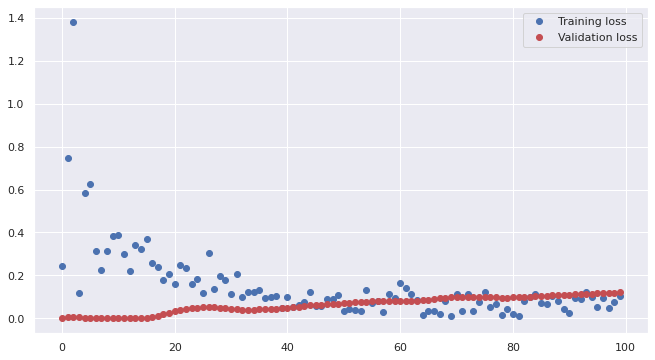

In [368]:
resid_HMLP, history_hybrid = forecast_HMLP_residuals(
    input_dim_hybrid_1, X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid)

resid_HMLP = scaler.inverse_transform(resid_HMLP)


plot_loss(history_hybrid)

In [314]:
resid_HMLP

array([[-36.157776],
       [-21.256792]], dtype=float32)

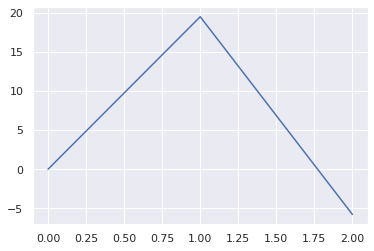

In [262]:
Zresid_HMLP = zero_centre(resid_HMLP)

plt.plot(Zresid_HMLP)
plt.show()

### Hybrid

In [263]:
Zresid_HMLP

[array([0.], dtype=float32),
 array([19.49281], dtype=float32),
 array([-5.7753525], dtype=float32)]

In [369]:
#List comprehension to combine ARIMA and HMLP forecast.
pred_hybrid = [a+b for a,b in zip(fscast3['mean'], resid_HMLP)]

In [362]:
fscast3['mean']

2021-01-01    626.254016
2021-02-01    558.414510
2021-03-01    578.774932
2021-04-01    539.527152
2021-05-01    677.859530
2021-06-01    730.463971
2021-07-01    793.057492
2021-08-01    716.544846
2021-09-01    743.181142
2021-10-01    776.712440
2021-11-01    713.337855
2021-12-01    823.949232
2022-01-01    730.624363
2022-02-01    606.600584
2022-03-01    630.927930
Freq: MS, Name: mean, dtype: float64

In [361]:
pred_hybrid


[array([499.8628], dtype=float32),
 array([541.3191], dtype=float32),
 array([443.36008], dtype=float32)]

In [370]:
test_d_h, pred_hybrid = equal_size(test_data['Delivery'], pred_hybrid)

y_actual_h,y_hat_h = comparison_graph(test_d_h, pred_hybrid)

print("Error measures for Hybrid:")
calculate_error_measures(test_d_h, pred_hybrid)

Error measures for Hybrid:
Mean Squared Error(MSE):  3541.554062963739
Mean Absolute Error(MAE):  58.61433755972331
Root Mean Squared Error(RMSE): 59.51095750333496
 Mean absolute percentage Error(MAPE): 0.0980415958195733


[3541.554062963739, 58.61433755972331, 59.51095750333496, 0.0980415958195733]

In [344]:
test_d_h

Month
2021-01-01    576.841947
Name: Delivery, dtype: float64

In [345]:
print(y_actual_h)

Empty DataFrame
Columns: [Actual Delivery]
Index: []


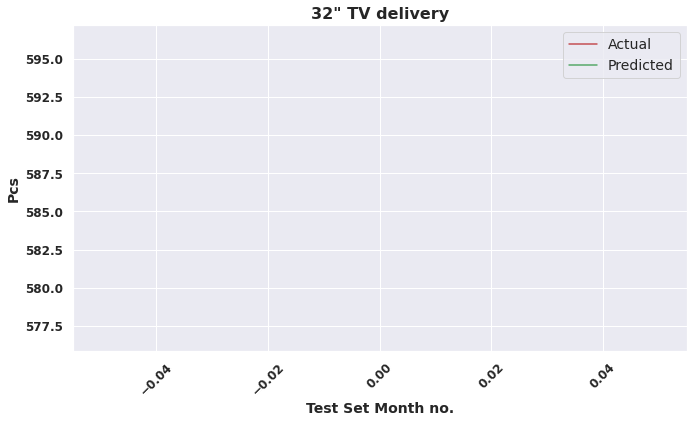

In [343]:
plt.figure(figsize=(11, 6))
plt.plot(y_actuald_h.values, color='r')
plt.plot(pred_hybrid , color='g')
    
plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('32" TV delivery', weight='bold', fontsize=16)
plt.ylabel('Pcs', weight='bold', fontsize=14)
plt.xlabel('Test Set Month no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(True)
    
plt.savefig("Hybrid_f1.png")
plt.savefig(f"{images_dir}/Hybrid_f1.png")   
plt.show()